In [4]:
"""
Preprocesses the input data frame by imputing missing values with median, standardizing the features, and applying PCA for dimensionality reduction.

Fits a KMeans clustering model on the PCA-transformed data and plots the clusters.
"""

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score


def preprocess(df):
    imputer = SimpleImputer(strategy="median")
    imputed_df = pd.DataFrame(imputer.fit_transform(df))
    scaled_df = StandardScaler().fit_transform(imputed_df)
    return scaled_df


def display_loadings(fitted_pca, features, figsize=(3, 10), component=0):
    loadings = fitted_pca.components_
    order = np.argsort(abs(loadings[component, :]))[::]  # Reverse the order
    loadings = loadings[:, order]
    features = [features[i] for i in order]

    loadings = pd.Series(loadings[component, :], index=features)
    fig, ax = plt.subplots(figsize=figsize)
    loadings.plot(kind="barh", ax=ax)

    return loadings


df = pd.read_csv("data/DS_salary_factors.csv", na_values=0)
df["GeoFips"] = df["GeoFips"].astype(str)

# Features selected by Nate
feature_names = [
    "2022 GDP",
    "Total Employment in State/Area",
    "2022 Median",
    "Poverty Percent",
    "Per Bach or Higher",
    "Uninsured",
    "2020 Life Expect",
    "Violent crime rate per 100,000 people",
    "Property crime rate per 100,000 people",
    "percent formal_vol",
    "percent Good Air Quality Days",
    "Gas Tax (cents)",
    "Internet Access Percent 2021",
    "Happiness",
    "A_MEDIAN",
]


In [5]:
# numeric_features = df.select_dtypes(include="number").columns


X = df[feature_names]


In [6]:
X = preprocess(X)
pca = PCA().fit(X)
X_pca = pca.transform(X)
captures_80 = (np.argwhere(pca.explained_variance_ratio_.cumsum() > 0.8) + 1).min()


In [7]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import spectral_clustering, AgglomerativeClustering, DBSCAN, OPTICS

# calculate silhoutte scores for k 2 to k 7
# repeat for kmeans and gmm

k_values = range(2, 8)
n_components = range(2, 8)
silhouette_scores = pd.DataFrame(
    columns=["Clusterer", "K", "N_components", "Silhouette"]
)
for c in n_components:
    for k in k_values:
        # KMeans
        X_pca = PCA(n_components=c).fit(X).transform(X)
        kmeans_cluster = KMeans(n_clusters=k, random_state=0).fit(X_pca)
        kmeans_labels = kmeans_cluster.labels_
        kmeans_score = silhouette_score(X_pca, kmeans_labels)
        new_row = pd.DataFrame(
            data=[["kmeans", k, c, kmeans_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )

        silhouette_scores = pd.concat([silhouette_scores, new_row])

        # GaussianMixture
        gmm_cluster = GaussianMixture(n_components=k).fit(X_pca)
        gmm_labels = gmm_cluster.predict(X_pca)
        gmm_score = silhouette_score(X_pca, gmm_labels)
        new_row = pd.DataFrame(
            data=[["GMM", k, c, gmm_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )

        silhouette_scores = pd.concat([silhouette_scores, new_row])

        # Spectral
        spectral_cluster = SpectralClustering(
            n_clusters=k,
        ).fit(X_pca)
        spectral_clustering_labels = spectral_cluster.labels_
        spectral_clustering_score = silhouette_score(X_pca, spectral_clustering_labels)
        new_row = pd.DataFrame(
            data=[["Spectral", k, c, spectral_clustering_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )
        # Agglomerative
        agglom_cluster = AgglomerativeClustering(
            n_clusters=k,
        ).fit(X_pca)
        agglom_labels = agglom_cluster.labels_
        agglom_score = silhouette_score(X_pca, agglom_labels)
        new_row = pd.DataFrame(
            data=[["Agglomerative", k, c, agglom_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )

        silhouette_scores = pd.concat([silhouette_scores, new_row])
        # DBSCAN
        dbscan_cluster = OPTICS(min_samples=30).fit(X_pca)
        dbscan_labels = dbscan_cluster.labels_
        if len(np.unique(dbscan_labels)) <= 1:
            dbscan_score = -1
        else:
            dbscan_score = silhouette_score(X_pca, dbscan_labels)

        new_row = pd.DataFrame(
            data=[["DBSCAN", k, c, dbscan_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )
    silhouette_scores = pd.concat([silhouette_scores, new_row])

silhouette_scores.sort_values("Silhouette", ascending=False, inplace=True)
silhouette_scores.reset_index(drop=True, inplace=True)
silhouette_scores.head(50)


/tmp/ipykernel_484348/1790482763.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  silhouette_scores = pd.concat([silhouette_scores, new_row])


,Clusterer,K,N_components,Silhouette
0,kmeans,2,2,0.447602
1,Agglomerative,2,2,0.435037
2,GMM,2,2,0.428467
3,kmeans,3,2,0.424344
4,GMM,3,2,0.417034
5,Agglomerative,3,2,0.408917
6,kmeans,4,2,0.402274
7,kmeans,5,2,0.400898
8,kmeans,6,2,0.399334
9,GMM,5,2,0.378766


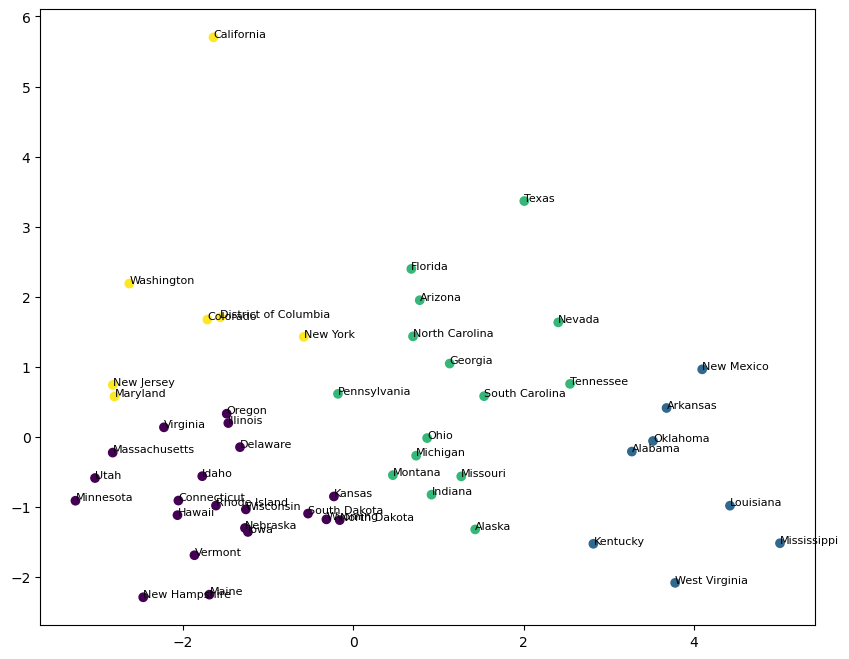

In [8]:
# cluster = KMeans(n_clusters=4, random_state=0).fit(X_pca)
# cluster = SpectralClustering(n_clusters=4, random_state=0).fit(X_pca)
cluster = KMeans(4).fit_predict(X_pca[:, :2])

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster, cmap="viridis")
for i, label in enumerate(df.GeoName):
    ax.text(X_pca[i, 0], X_pca[i, 1], label, fontsize=8)


percent Good Air Quality Days            -0.000372
Total Employment in State/Area           -0.019449
Property crime rate per 100,000 people    0.081001
2022 GDP                                 -0.100565
Gas Tax (cents)                          -0.104456
Violent crime rate per 100,000 people     0.199786
percent formal_vol                       -0.202926
Internet Access Percent 2021             -0.208514
Uninsured                                 0.243715
A_MEDIAN                                 -0.265959
Per Bach or Higher                       -0.322166
Happiness                                -0.380444
2022 Median                              -0.381703
2020 Life Expect                         -0.401457
Poverty Percent                           0.402417
dtype: float64

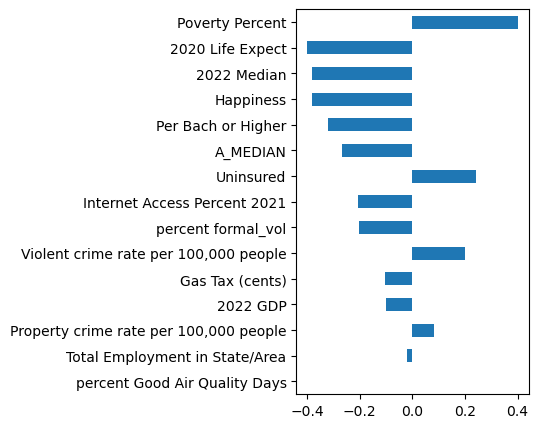

In [9]:
display_loadings(pca, feature_names, figsize=(3, 5), component=0)


2020 Life Expect                          0.062157
Happiness                                 0.093815
2022 Median                               0.097949
Poverty Percent                           0.124303
Per Bach or Higher                        0.147039
Internet Access Percent 2021             -0.178594
Uninsured                                 0.208764
Gas Tax (cents)                           0.220756
A_MEDIAN                                  0.263256
Violent crime rate per 100,000 people     0.276724
percent formal_vol                       -0.296955
2022 GDP                                  0.313653
Property crime rate per 100,000 people    0.323749
percent Good Air Quality Days            -0.337715
Total Employment in State/Area            0.514930
dtype: float64

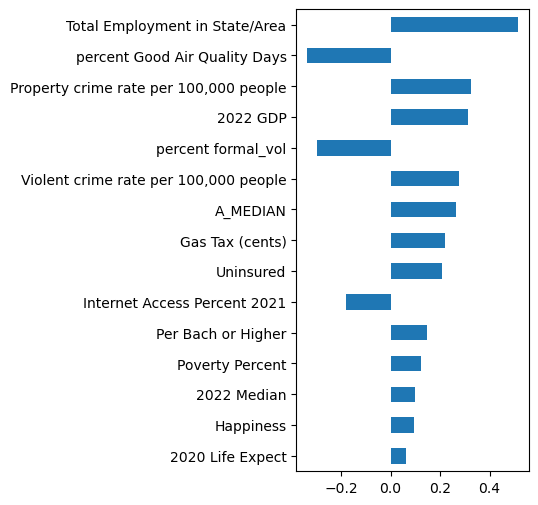

In [10]:
display_loadings(pca, feature_names, figsize=(3, 6), component=1)


In [39]:
fips_to_state = {
    "01": "AL",
    "02": "AK",
    "04": "AZ",
    "05": "AR",
    "06": "CA",
    "08": "CO",
    "09": "CT",
    "10": "DE",
    "11": "DC",
    "12": "FL",
    "13": "GA",
    "15": "HI",
    "16": "ID",
    "17": "IL",
    "18": "IN",
    "19": "IA",
    "20": "KS",
    "21": "KY",
    "22": "LA",
    "23": "ME",
    "24": "MD",
    "25": "MA",
    "26": "MI",
    "27": "MN",
    "28": "MS",
    "29": "MO",
    "30": "MT",
    "31": "NE",
    "32": "NV",
    "33": "NH",
    "34": "NJ",
    "35": "NM",
    "36": "NY",
    "37": "NC",
    "38": "ND",
    "39": "OH",
    "40": "OK",
    "41": "OR",
    "42": "PA",
    "44": "RI",
    "45": "SC",
    "46": "SD",
    "47": "TN",
    "48": "TX",
    "49": "UT",
    "50": "VT",
    "51": "VA",
    "53": "WA",
    "54": "WV",
    "55": "WI",
    "56": "WY",
}
#pad with zeros and extract first two digits of GeoFips column to create ST_FIPS
df["ST_FIPS"] = df["GeoFips"].str.pad(5, "left", "0").str.slice(0, 2)
# convert two digit fips to state abbreviation using the above defined mapping
df["ST_ABR"] = df["ST_FIPS"].map(fips_to_state)

# put the cluster label in the dataframe
df["cluster"] = cluster

import plotly.express as px

# Define a discrete color map
color_discrete_map = {0: "red", 1: "blue", 2: "green", 3: "orange"}

# Create a choropleth map
fig = px.choropleth(
    df,  # Dataframe
    locations="ST_ABR",  # Column with location info
    color="cluster",  # Column with the color values
    color_discrete_map=color_discrete_map,  # Mapping of cluster to color
    locationmode="USA-states",  # Specifies the set of locations used in 'locations'
    scope="usa",  # Scope of the map
    title="K-Means Clustering of US States",
)
fig.show()
